In [150]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [175]:
# Define stock ticker, start, and end dates
ticker = "AAPL"  # Apple Inc.
start_date = "2000-01-01"
end_date = "2025-01-01"

# Fetch historical data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Optional: Rename other columns for clarity
stock_data.columns = ["Close", "High", "Low", "Open", "Volume"]

# Ensure the dataframe is sorted by date
stock_data = stock_data.sort_index()

# Display last few rows
print(stock_data.tail())

[*********************100%***********************]  1 of 1 completed

                 Close        High         Low        Open    Volume
Date                                                                
2024-12-24  257.916443  257.926411  255.009620  255.209412  23234700
2024-12-26  258.735504  259.814335  257.347047  257.906429  27237100
2024-12-27  255.309296  258.415896  252.782075  257.546826  42355300
2024-12-30  251.923019  253.221595  250.474615  251.952985  35557500
2024-12-31  250.144974  253.001833  249.156056  252.162760  39480700


In [176]:
stock_data.count()

Close     6289
High      6289
Low       6289
Open      6289
Volume    6289
dtype: int64

In [177]:
stock_data.to_csv("AAPL_stock_data.csv",index = False)

In [178]:
stock_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600
2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400


In [179]:
stock_data.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=6289, freq=None)

<Figure size 1200x600 with 0 Axes>

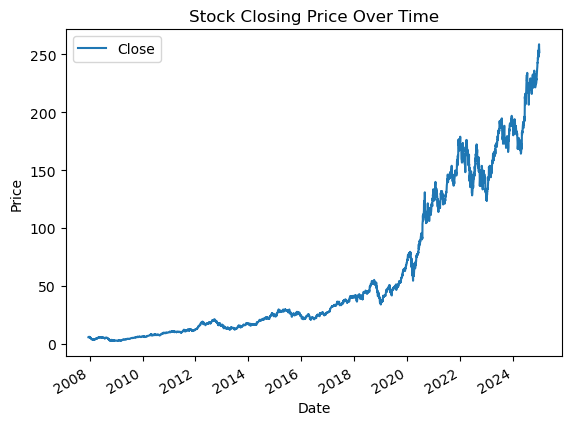

In [256]:
plt.figure(figsize=(12,6))
stock_data.plot.line(y="Close",use_index=True)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Closing Price Over Time")
plt.legend();

set up a target

In [181]:
stock_data["Tomorrow"] = stock_data["Close"].shift(-1)
stock_data.head()

,Close,High,Low,Open,Volume,Tomorrow
Date,,,,,,
2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800,0.771149
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,0.782433
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600,0.714723
2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800,0.748578
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400,0.735412


In [182]:
stock_data["Target"] = (stock_data["Tomorrow"] > stock_data["Close"]).astype(int)
stock_data.head()

,Close,High,Low,Open,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800,0.771149,0
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,0.782433,1
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600,0.714723,0
2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800,0.748578,1
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400,0.735412,0


#

# *Building the model*

*using RandomForestClassifier:*
- It is resistant to overfitting  
- Runs really quickly  
- Picks up on non-linear tendencies in the data  

In [228]:
predictors = ["Close","Volume","Open","High","Low"]

In [229]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds = model.predict(test[Predictors])
    preds = pd.Series(preds,index = test.index,name ="Predictions")
    combined = pd.concat([test["Target"],preds],axis = 1)
    return combined

In [230]:
def backtest(data,model,predictors,start=2500,step=250):
    all_predictions = []

    for i in range(start,data.shape[0],step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [232]:
predictions = backtest(stock_data,model,predictors)

In [237]:
predictions["Predictions"].value_counts()

Predictions
0    1152
1     636
Name: count, dtype: int64

In [193]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5257936507936508

In [191]:
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.531539
0    0.468461
Name: count, dtype: float64

In [194]:
#The mode prediction is a bit too low 

In [209]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_average = stock_data.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    stock_data[ratio_column] = stock_data["Close"]/rolling_average["Close"]

    trend_column = f"Trend_{horizon}"
    stock_data[trend_column] = stock_data.shift(1).rolling(horizon).sum()["Target"]

    new_predictors +=[ratio_column,trend_column]

In [210]:
stock_data.head()

,Close,High,Low,Open,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-12-26,0.312672,0.314629,0.306052,0.306202,103695200,0.318240,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-29,0.318240,0.318390,0.313876,0.314629,233458400,0.320196,1,1.008825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-30,0.320196,0.323507,0.318240,0.318691,204853600,0.321550,1,1.003063,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-31,0.321550,0.323957,0.318691,0.321249,174451200,0.320196,0,1.002110,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-02,0.320196,0.327268,0.318691,0.324258,144642400,0.333588,1,0.997890,1.0,1.005101,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
stock_data = stock_data.dropna()
stock_data.head()

,Close,High,Low,Open,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2007-12-17,5.549258,5.797530,5.506526,5.739450,1024693600,5.506525,0,0.984018,0.0,0.974609,2.0,1.058724,33.0,1.481352,138.0,2.858940,543.0
2007-12-18,5.506525,5.637432,5.374715,5.613057,1222603200,5.510740,1,0.996135,0.0,0.972822,2.0,1.047095,32.0,1.465393,137.0,2.829361,542.0
2007-12-19,5.510740,5.556483,5.443932,5.506527,827478400,5.633822,1,1.000383,1.0,0.981645,2.0,1.044912,32.0,1.461908,138.0,2.823995,542.0
2007-12-20,5.633822,5.652480,5.517060,5.580256,774057200,5.835450,1,1.011044,2.0,1.008566,2.0,1.064763,33.0,1.489598,139.0,2.879231,542.0
2007-12-21,5.835450,5.835450,5.714474,5.721395,993960800,5.982607,1,1.017580,2.0,1.040714,3.0,1.098765,33.0,1.537443,140.0,2.973893,543.0


In [225]:
model = RandomForestClassifier(n_estimators = 200,min_samples_split = 50 ,random_state = 1)

In [233]:
def predict(train,test,predictors,model2):
    model.fit(train[predictors],train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index,name ="Predictions")
    combined = pd.concat([test["Target"],preds],axis = 1)
    return combined

In [234]:
Predictions = backtest(stock_data,model,new_predictors)

In [236]:
Predictions["Predictions"].value_counts()

Predictions
0.0    1555
1.0     233
Name: count, dtype: int64

In [239]:
precision_score(Predictions["Target"],predictions["Predictions"])

0.5644654088050315

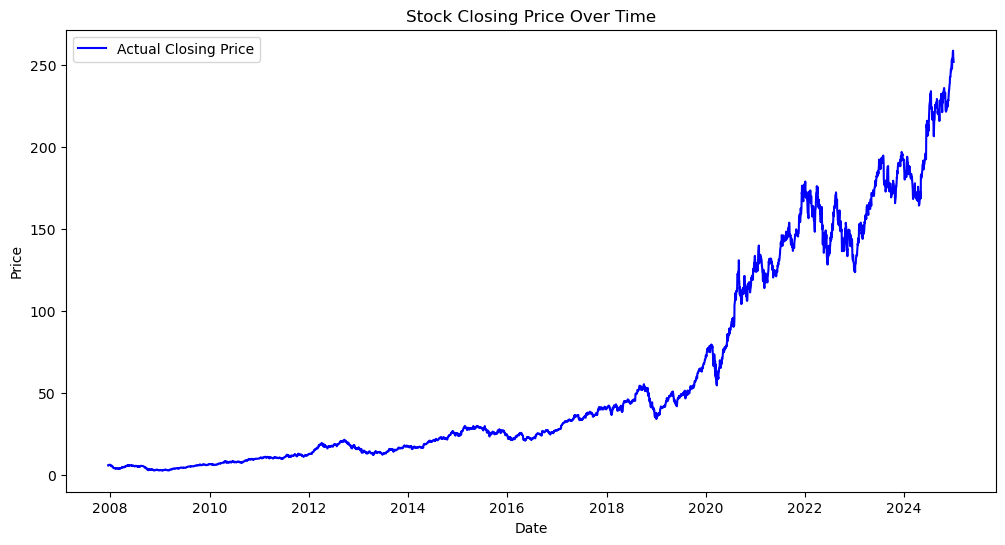

In [246]:
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, stock_data["Close"], label="Actual Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Closing Price Over Time")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
stock_data.plot.line(y="Close",use_index=True);